In [1]:
from graphrole import RoleExtractor, RecursiveFeatureExtractor
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import math
import csv

import embeddings
import metricas
import modelos
import motifs

random.seed(42)

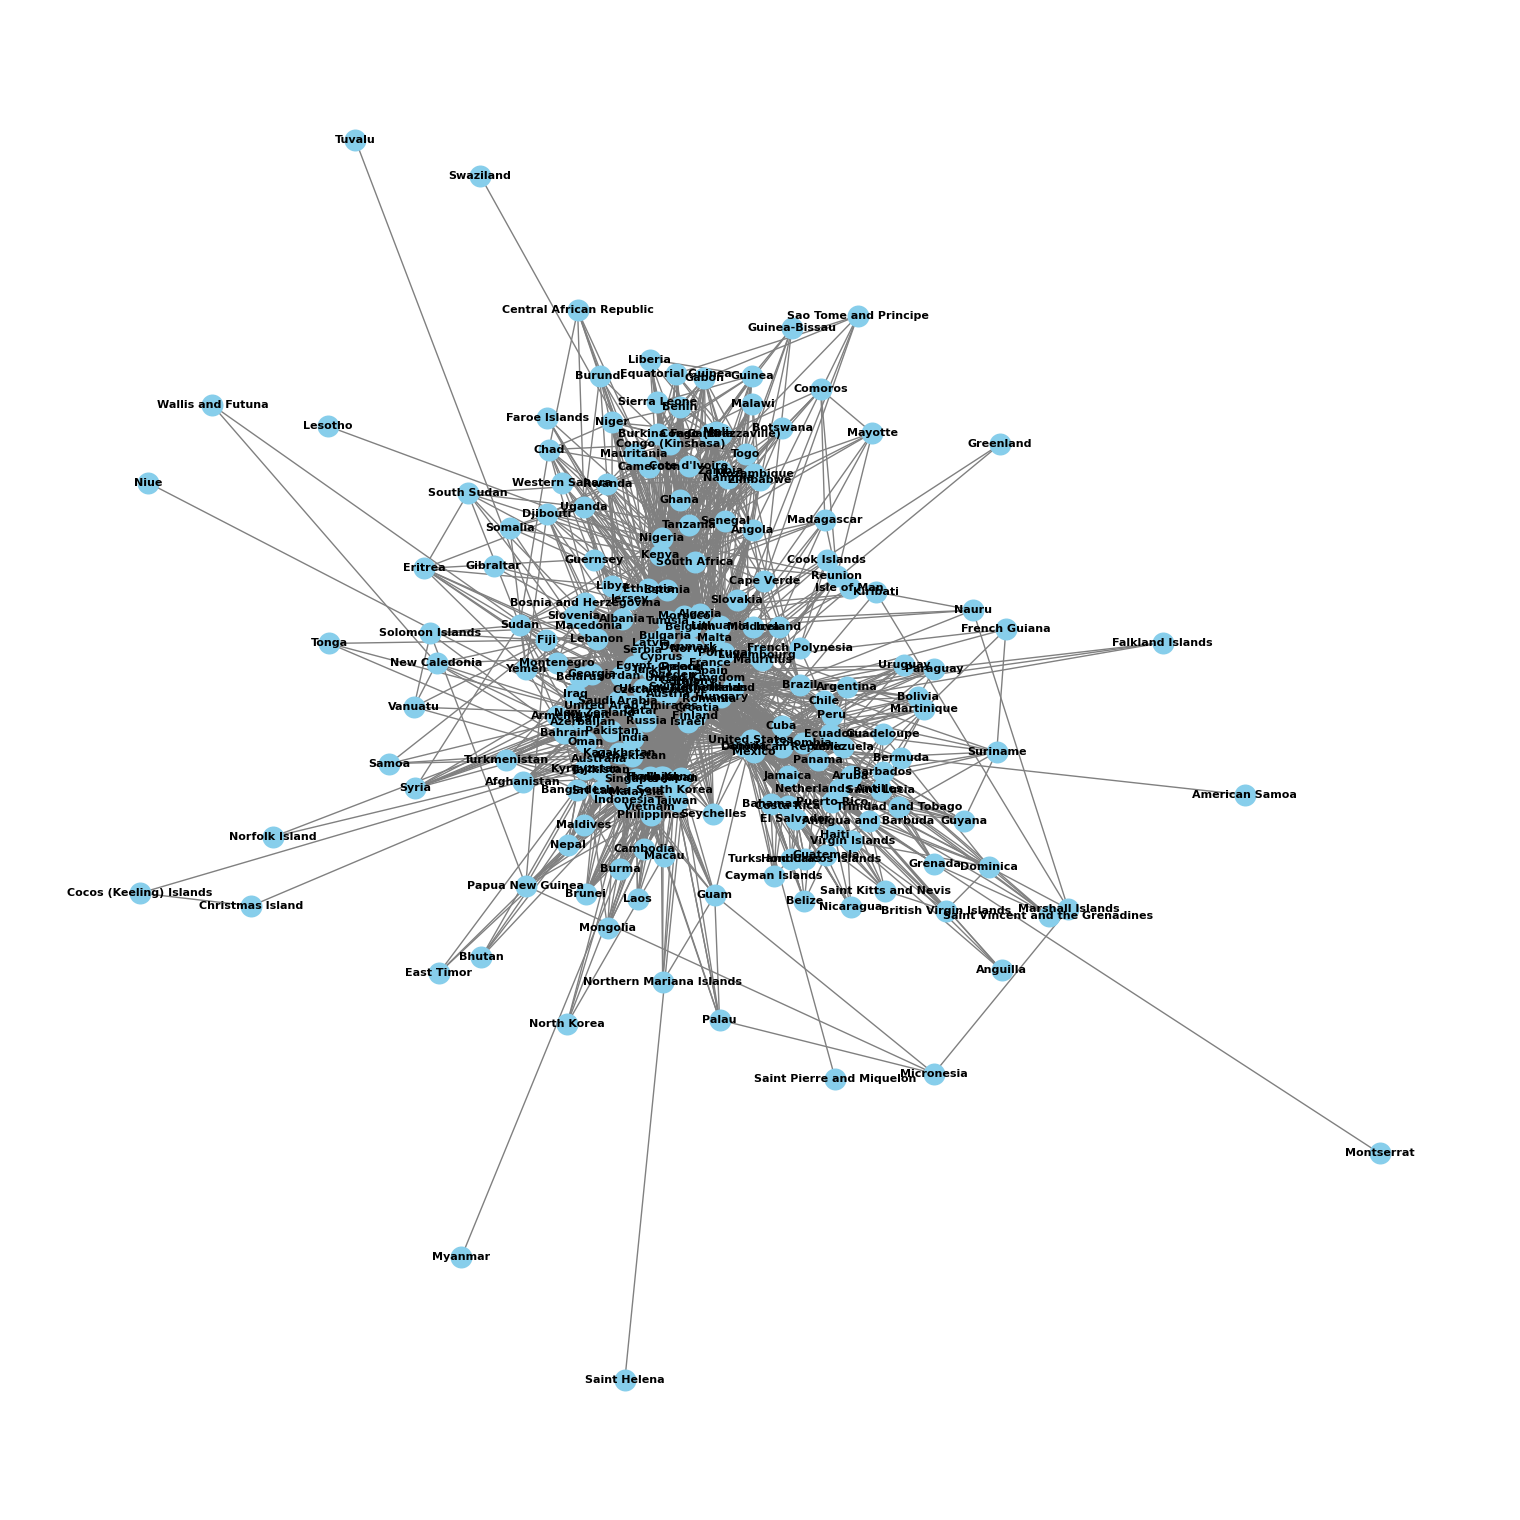

In [2]:
# Lee el archivo word.CSV
df = pd.read_csv('World.csv')

G = nx.Graph()

# Agrega nodos y aristas al grafo
for index, row in df.iterrows():
    G.add_edge(row['Origen'], row['Destino'], weight=row['ConexionAeropuertos'])

# Viendo el grafo 
plt.figure(figsize=(15, 15))
nx.draw(G, 
        with_labels=True, 
        node_size=250, 
        node_color="skyblue", 
        font_size=8, 
        font_color="black", 
        font_weight="bold", 
        edge_color="gray", 
        linewidths=0.01)
plt.show()

In [3]:
'''
---: Analisis basico de la red :---

1. Determinar
a) El diámetro de la red.
b) El grado promedio de la red.
c) El coeficiente de clustering promedio de la red.
'''


# a) El diámetro de la red.
diameter = nx.diameter(G)


# b) El grado promedio de la red.
def avg_degree(G):
    edges = 0
    degress = list(G.degree)
    for country,degree in degress:
        edges += degree
    avg_degree = edges / (1*len(degress))
    return avg_degree


# c) El coeficiente de clustering promedio de la red.
def coef_clustering(G):
    avg_clus = 0
    clustering_rank = nx.clustering(G)
    for country, c in clustering_rank.items():
        avg_clus+=c
    avg_clus = avg_clus/len(clustering_rank)
    return avg_clus


print(f"El diámetro del grafo es: {diameter}")
print(f'El grado promedio de la red es {round(avg_degree(G),2)}') 
print(f'El coeficiente de clustering promedio de la red {round(coef_clustering(G),2)}')

El diámetro del grafo es: 5
El grado promedio de la red es 24.91
El coeficiente de clustering promedio de la red 0.66


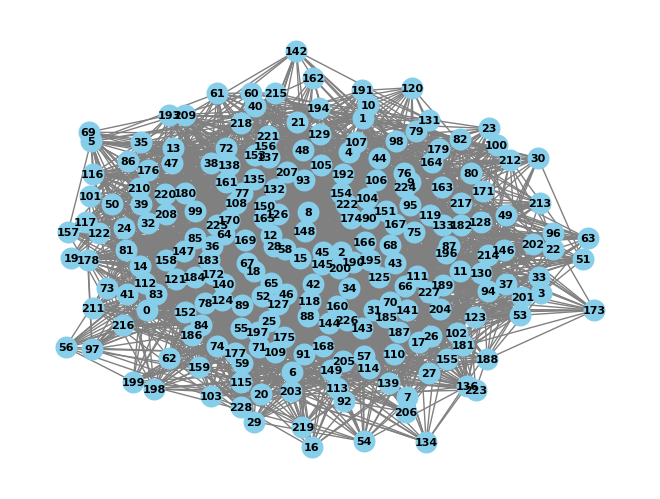

El diámetro del grafo es: 3
El grado promedio de la red es 24.97
El coeficiente de clustering promedio de la red 0.11


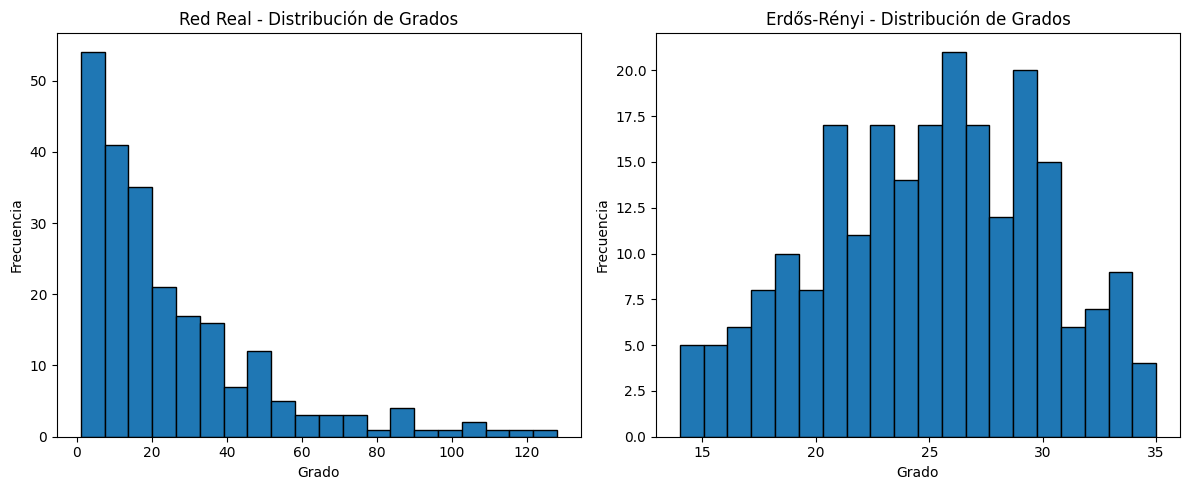

In [4]:
'''
2. Modelacion
a) Obtener una simulación de un modelado de Erdös-Rényi que corresponda a los pará-
metros de esta red.

b) Obtener una simulación de un modelado de Preferential Attachment (ley de potencias)
que corresponda a los parámetros de esta red.

c) Obtener una representación de anonymous walks tanto de la red original como para
las dos simuladas en los puntos a y b. Determinar por distancia coseno cuál sería la
simulación más afín
'''

# A) Simulación de un modelado de Erdös-Rényi
nodes = len(G.nodes)
k = metricas.grado_promedio(G)


G_erdos_renyi = modelos.erdos_renyi(nodes,k)
pos = nx.spring_layout(G_erdos_renyi, k=1)
nx.draw(G_erdos_renyi, 
        pos, 
        with_labels=True, 
        node_size=250, 
        node_color="skyblue", 
        font_size=8, 
        font_color="black", 
        font_weight="bold", 
        edge_color="gray", 
        linewidths=0.01)
plt.show()

# Metricas de la red Erdös-Rényi.
print(f"El diámetro del grafo es: {nx.diameter(G_erdos_renyi)}")
print(f'El grado promedio de la red es {round(avg_degree(G_erdos_renyi),2)}') 
print(f'El coeficiente de clustering promedio de la red {round(coef_clustering(G_erdos_renyi),2)}')

# Comparacion distribucion de los grados.
degrees = [degree for node, degree in G.degree()]
degrees_erdos = [degree for node, degree in G_erdos_renyi.degree()]

plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=20, edgecolor='k')
plt.title("Red Real - Distribución de Grados")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")

plt.subplot(1, 2, 2)
plt.hist(degrees_erdos, bins=20, edgecolor='k')
plt.title("Erdős-Rényi - Distribución de Grados")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [5]:
# Guardamos la red modelada para luego importarla en gephi.
with open("erdos_renyi.csv", 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['source', 'target', 'weight'])  # Escribir encabezados

    for edge in G_erdos_renyi.edges():
        csv_writer.writerow([edge[0], edge[1], 1])

Alfa: 2.449890843293105 (Estimador Maxima Verosimilitud)
Alfa:  2.6


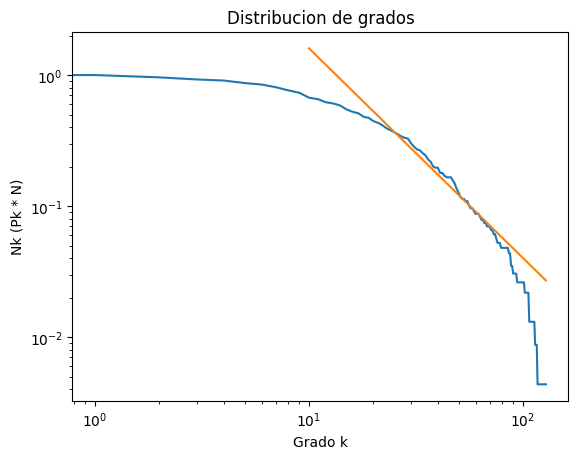

In [6]:
def graficar_distribuciones(distribucion_grados):
    rango = np.arange(len(distribucion_grados))
    plt.plot(rango, distribucion_grados)

    # Para obtener el valor de alfa vistualmente
    x_m = 10
    alpha_prima = 1.6
    z = alpha_prima*(x_m**alpha_prima)
    exponencial = list(map(lambda k: z * k ** (-alpha_prima), rango[x_m:]))
    plt.plot(rango[x_m:], exponencial)
    print("Alfa: ", alpha_prima + 1)

    plt.xlabel("Grado k")
    plt.ylabel("Nk (Pk * N)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Distribucion de grados")
    plt.show()

alpha = metricas.alfa_preferential_attachment(G,10)
print(f'Alfa: {alpha} (Estimador Maxima Verosimilitud)')
dist_grado = metricas.distrubucion_ccdf(G)
graficar_distribuciones(dist_grado)

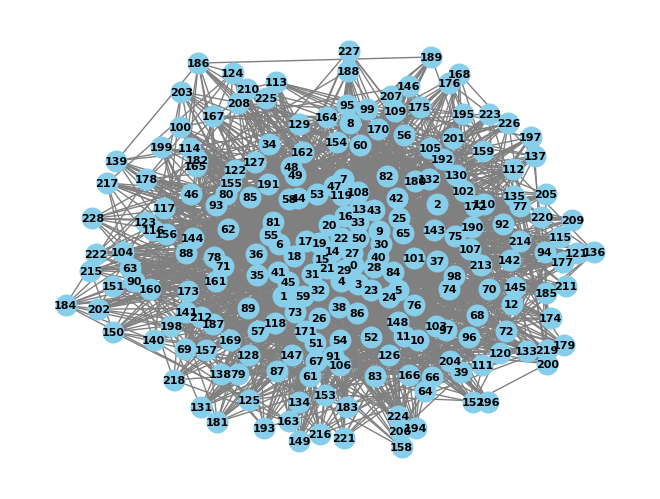

El diámetro del grafo es: 3
El grado promedio de la red es 22.74
El coeficiente de clustering promedio de la red 0.19


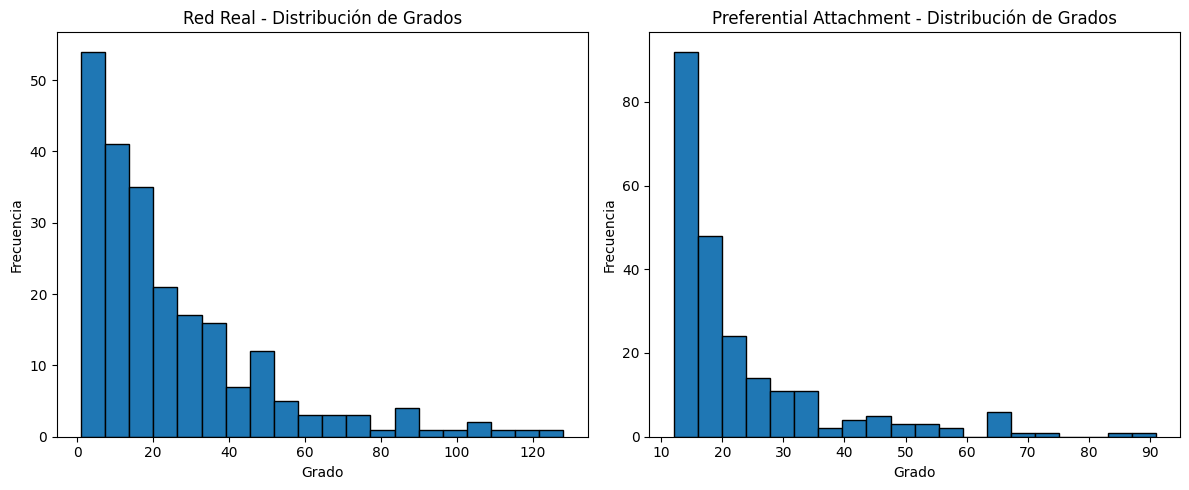

In [7]:
# Ambos metodos para calcular alpha dieron similares
nodes = G.number_of_nodes()

G_preferential_attachment = modelos.preferential_attachment(False, alpha, nodes, round(metricas.grado_promedio(G)/2))

# https://barabasi.com/f/622.pdf 
G_preferential_attachment = nx.barabasi_albert_graph(nodes, round(metricas.grado_promedio(G)/2))

pos = nx.spring_layout(G_preferential_attachment, k=1)
nx.draw(G_preferential_attachment, 
        pos, 
        with_labels=True, 
        node_size=250, 
        node_color="skyblue", 
        font_size=8, 
        font_color="black", 
        font_weight="bold", 
        edge_color="gray", 
        linewidths=0.01)
plt.show()

# Metricas de la red Preferential Attachment.
print(f"El diámetro del grafo es: {nx.diameter(G_preferential_attachment)}")
print(f'El grado promedio de la red es {round(metricas.grado_promedio(G_preferential_attachment),2)}') 
print(f'El coeficiente de clustering promedio de la red {round(coef_clustering(G_preferential_attachment),2)}')

# Comparacion distribucion de los grados.
degrees = [degree for node, degree in G.degree()]
degrees_preferential_attachment = [degree for node, degree in G_preferential_attachment.degree()]

plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=20, edgecolor='k')
plt.title("Red Real - Distribución de Grados")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")

plt.subplot(1, 2, 2)
plt.hist(degrees_preferential_attachment, bins=20, edgecolor='k')
plt.title("Preferential Attachment - Distribución de Grados")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [8]:
# Guardamos la red modelada para luego importarla en gephi.
with open("preferential_attachment.csv", 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['source', 'target', 'weight'])  # Escribir encabezados

    for edge in G_preferential_attachment.edges():
        csv_writer.writerow([edge[0], edge[1], 1])

In [9]:
#c) Obtener una representación de anonymous walk

# Valores de ejemplo del paper
η = 877
l = 8
ε = 0.1
δ = 0.01

walks_G, vec_G = embeddings.anoymous_walks(G,l)
walks_G_erdos, vec_G_erdos = embeddings.anoymous_walks(G_erdos_renyi,l)
walks_G_pref_attach, vec_G_pref_attach = embeddings.anoymous_walks(G_preferential_attachment,l)

dist_G_vs_G_erdos = metricas.distancia_coseno(vec_G,vec_G_erdos)
dist_G_vs_G_pref_attach = metricas.distancia_coseno(vec_G,vec_G_pref_attach)

print(f'Distancia coseno Grafo Real vs Erdos renyi: {round(dist_G_vs_G_erdos,5)}')
print(f'Distancia coseno Grafo Real vs Preferential Attachment: {round(dist_G_vs_G_pref_attach,5)}')

Distancia coseno Grafo Real vs Erdos renyi: 0.00063
Distancia coseno Grafo Real vs Preferential Attachment: 0.00042


In [10]:
'''
6. Detectar los roles en dicha red utilizando el algoritmo RolX, explicando el resultado obtenido
'''
feature_extractor = RecursiveFeatureExtractor(G, attributes=True, attributes_include=['weight'])
features = feature_extractor.extract_features()

role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)

for k,v in role_extractor.roles.items():
    print(f'{k},{v}')

Afghanistan,role_2
Albania,role_4
Algeria,role_3
American Samoa,role_2
Angola,role_3
Anguilla,role_2
Antigua and Barbuda,role_3
Argentina,role_3
Armenia,role_2
Aruba,role_2
Australia,role_1
Austria,role_1
Azerbaijan,role_3
Bahamas,role_3
Bahrain,role_3
Bangladesh,role_3
Barbados,role_3
Belarus,role_1
Belgium,role_1
Belize,role_2
Benin,role_2
Bermuda,role_4
Bhutan,role_2
Bolivia,role_3
Bosnia and Herzegovina,role_4
Botswana,role_2
Brazil,role_3
British Virgin Islands,role_2
Brunei,role_2
Bulgaria,role_4
Burkina Faso,role_2
Burma,role_2
Burundi,role_2
Cambodia,role_2
Cameroon,role_2
Canada,role_1
Cape Verde,role_3
Cayman Islands,role_2
Central African Republic,role_2
Chad,role_2
Chile,role_3
China,role_1
Christmas Island,role_2
Cocos (Keeling) Islands,role_2
Colombia,role_3
Comoros,role_2
Congo (Brazzaville),role_2
Congo (Kinshasa),role_2
Cook Islands,role_2
Costa Rica,role_3
Cote d'Ivoire,role_3
Croatia,role_4
Cuba,role_3
Cyprus,role_1
Czech Republic,role_1
Denmark,role_1
Djibouti,role_

In [11]:
'''
7) Determinar los puentes (globales o locales) en dicha red
'''
print(f'Puentes globales')
for u,v in list(nx.bridges(G)):
    print(f'{u} ({len(G[u])}) <----> {v} ({len(G[v])})') 

print()
print(f'Puentes locales')
for u,v,alt_path in list(nx.local_bridges(G)):
    print(f'{u} ({len(G[u])}) <----> {v} ({len(G[v])})') 


Puentes globales
Fiji (17) <----> Tuvalu (1)
United States (106) <----> American Samoa (1)
United Kingdom (113) <----> Saint Helena (1)
Canada (72) <----> Saint Pierre and Miquelon (1)
Antigua and Barbuda (21) <----> Montserrat (1)
New Zealand (25) <----> Niue (1)
South Africa (47) <----> Lesotho (1)
South Africa (47) <----> Swaziland (1)
Burma (15) <----> Myanmar (1)

Puentes locales
Papua New Guinea (10) <----> Micronesia (4)
Fiji (17) <----> Tuvalu (1)
Micronesia (4) <----> Marshall Islands (4)
United States (106) <----> American Samoa (1)
United Kingdom (113) <----> Saint Helena (1)
Canada (72) <----> Saint Pierre and Miquelon (1)
Antigua and Barbuda (21) <----> Montserrat (1)
New Zealand (25) <----> Niue (1)
South Africa (47) <----> Lesotho (1)
South Africa (47) <----> Swaziland (1)
Burma (15) <----> Myanmar (1)


In [12]:
df = pd.read_csv('latin.csv')

G_latin = nx.Graph()

# Agrega nodos y aristas al grafo
for index, row in df.iterrows():
    G_latin.add_edge(row['Source'], row['Target'], weight=row['Weight'])



In [13]:
from motifs.calculos import significance_profile

MAX_MOTIFS = 5

motifs_G = motifs.calculos.calcular_motifs(G_latin, MAX_MOTIFS)

In [ ]:
base_line_g = G_erdos_renyi
n = G_latin.number_of_nodes()
p = metricas.grado_promedio(G_latin) / (n - 1)

N_rand_prom, N_rand_stds = motifs.calculos.motif_grafo_eleatorios(lambda: nx.erdos_renyi_graph(n, p), MAX_MOTIFS)

N_real = motifs_G

SP = significance_profile(N_real, N_rand_prom, N_rand_stds)

Iteracion 1
Iteracion 2; anterior: 770.56 segs
Iteracion 3; anterior: 852.07 segs
Iteracion 4; anterior: 1082.88 segs
